In [34]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import  davies_bouldin_score
from tqdm.auto import tqdm

from collections import Counter


In [2]:
import os
import re
PICKLE_REGEX = r"([a-z_]*)-([a-z_]*)_clusterer\.pickle"
pickle_files = []
for root, dirs, files in os.walk("./data/BigQuery/clusters/feature_set_2", topdown=False):
    for name in files:
        regex_match = re.match(PICKLE_REGEX, name)
        if regex_match:
            file_info = {}
            file_info["path"] = os.path.join(root, name)
            file_info["file_name"] = name
            file_info["features"] = [regex_match.group(1), regex_match.group(2)]
            
            pickle_files += [file_info.copy()]

In [3]:
labels = []
with open(pickle_files[0]["path"], "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    print(labels, len(labels), print(cluster_pred))

HDBSCAN(cluster_selection_epsilon=0.01, min_cluster_size=500, min_samples=100,
        prediction_data=True)
[2 7 7 ... 7 7 7] 115050 None


In [4]:
def random_sample_clusters(sample_df, labels):
    sample_size = len(sample_df)
    labels_cat = np.unique(labels)
    prob_dist = {k:v/sample_size for k,v in dict(Counter(labels)).items()}
    results = []
    return np.random.choice(labels_cat, sample_size, p=[prob_dist[l] for l in labels_cat])

def get_high_freq_users(user_freq_dist, freq_thresh = 1000):
    users = []
    for user, freq in user_freq_dist:
        if freq < freq_thresh: continue
        users += [user]
    return users

def purity(cluster_labels, gold_labels):
    cluster_num = np.unique(cluster_labels).shape[0]
    cluster_sets = {}
    for cluster_label in np.unique(cluster_labels):
        cluster_sets[cluster_label] = []
    
    for idx, cluster_label in enumerate(cluster_labels):
        cluster_sets[cluster_label].append(gold_labels[idx])
    
    total_correct_pred = 0
    for c in np.unique(cluster_labels):
        label_counter = Counter(cluster_sets[c])
        pred_label, _ = label_counter.most_common(1)[0]
        total_correct_pred += label_counter[pred_label]
    
    purity = total_correct_pred / len(cluster_labels)
    
    return purity


In [5]:
import pandas as pd


In [6]:

bq_df = pd.read_csv("data/bigquery_metric_20220526.csv")

In [7]:
bq_df["cluster"] = labels

In [8]:
bq_df

,id,repository,filepath,forks,issue_events,stars,parse_error,line_count,comment_count,comment_avg_len,...,func_async_count,generators,lower_case_class,snake_case_class,upper_camel_case_method,other_case_method,upper_case_class,lower_camel_case_class,upper_case_method,cluster
0,7efee2302abe88318188446cff57db3374308a1d,jbkalmbach/kbmod,analysis/rawGenerated/batchGenerate.py,1,32,1,1,51.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,e4bf9e1e79620474ce8668253ec256303087918e,pymedusa/SickRage,medusa/providers/torrent/rss/rsstorrent.py,22,763,27,1,170.0,8.0,17.625000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
2,e67032e5fff2307de9e0f92187793914251d9783,ipdata/python,ipdata/test_cli.py,6,15,16,1,135.0,34.0,37.352941,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
3,7c14c480a61dd134e02364f763a6aa57cc0c9126,demisto/content,Packs/AnsibleLinux/Integrations/AnsibleACME/An...,1328,52,797,1,59.0,11.0,26.818182,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,d7e0bb47b97770961a2436bdded35e8bb1e9b5ab,hidat/audio_pipeline,review_parser/mb_release.py,1,26,4,1,76.0,12.0,37.166667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115045,49912608b288337ba2a4a18c247c1104faa2a5de,oscarbranson/latools,latools/helpers/plot.py,11,77,9,1,1292.0,201.0,38.950249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
115046,289a01aba96436c4459b965a1de7544ad5dc311d,erjac77/ansible-module-f5bigip,library/f5bigip_ltm_monitor_snmp_dca.py,5,72,6,1,194.0,17.0,37.235294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
115047,e3274c379b0db385868537bddf79a9014e72f0fe,python-hyper/hyper-h2,test/test_config.py,139,376,754,1,145.0,1.0,23.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7
115048,73ca68865447b1b8df1c5fca3537c6a6f55b0ebb,techbureau/zaifbot,tests/trade/test_trade.py,14,198,42,1,48.0,0.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


In [9]:
users = []
repos = []
for user_repo in bq_df["repository"]:
    temp = user_repo.split("/")
    users += [temp[0]]
    repos += [temp[1]]
    
bq_df["user_name"] = users
bq_df["repo_name"] = repos

# User Experiment

In [10]:
user_counter = Counter(users)
user_freq_dist = user_counter.most_common(2)[:]
selected_users = get_high_freq_users(user_freq_dist, 0)
user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
user_bool = bq_df['user_name'].apply(lambda user: user in selected_users)
user_freq_dist

[('plotly', 2004), ('google', 1054)]

In [11]:
sample = bq_df[user_bool].loc[:]
author_class = sample["user_name"].apply(lambda user: user_to_idx[user]).to_numpy()

In [12]:
baseline_clusters = random_sample_clusters(sample, author_class)
purity(baseline_clusters, author_class)

0.6553302812295618

In [13]:
purity(sample["cluster"].to_numpy(), author_class)

0.8172007848266841

In [14]:
#internal metrics are generated now and everything is stored in dataframe should be ready for clustering
target_features = [
     'snake_case_var_ratio',
     'snake_case_class_ratio',
     'snake_case_method_ratio',
     'upper_camel_case_var_ratio',
     'upper_camel_case_class_ratio',
     'upper_camel_case_method_ratio',
     'lower_camel_case_var_ratio',
     'lower_camel_case_class_ratio',
     'lower_camel_case_method_ratio',
     'func_decorators_avg',
     'class_decorators_avg',
     'class_parents_avg',
     'comprehensions_avg',
     'generators_avg',
     'lambda_avg',
     'comment_density',
     'ds_density',
]
X = bq_df[target_features].to_numpy()
X.shape

(115050, 17)

In [21]:
print("DB Index:")
print(davies_bouldin_score(X[user_bool], sample["cluster"].to_numpy()) )

DB Index:


NameError: name 'user_bool' is not defined

In [56]:

projections = []
with open("data/BigQuery/clusters/feature_set_2/projection.txt") as f:
    for line in tqdm(f.readlines()):
        val_str_list = line.split()
        projections += [[float(val_str_list[0]), float(val_str_list[1])]]
proj = np.array(projections)

  0%|          | 0/115050 [00:00<?, ?it/s]

In [115]:

import seaborn as sns


color_palette = sns.color_palette('Paired', 110000)
cluster_colors = [color_palette[x] if x >= 0
              else (0.5, 0.5, 0.5)
              for x in cluster_pred.labels_]
# cluster_member_colors = [sns.desaturate(x, p) for x, p in
#                          zip(cluster_colors, cluster_pred.probabilities_)]

In [119]:
np.array(cluster_colors)[user_bool]

array([[0.5       , 0.5       , 0.5       ],
       [0.12156863, 0.47058824, 0.70588235],
       [0.12156863, 0.47058824, 0.70588235],
       ...,
       [0.12156863, 0.47058824, 0.70588235],
       [0.5       , 0.5       , 0.5       ],
       [0.5       , 0.5       , 0.5       ]])

In [ ]:
# external eval on repo
# plot on different 

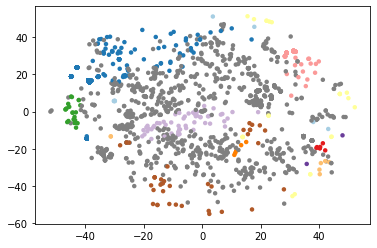

In [137]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purities = []
db_indexes = []
feat_1 = []
feat_2 = []

for pickle_file in pickle_files:
    with open(pickle_file["path"], "rb") as file:
        cluster_pred = pickle.load(file)
        labels = cluster_pred.labels_
        cluster_num = len(np.unique(labels))
        p = purity(labels[user_bool], author_class)
        X = bq_df[pickle_file["features"]].to_numpy()
        db_index = davies_bouldin_score(X[user_bool], labels[user_bool])
        
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        feat_1 += [pickle_file["features"][0]]
        feat_2 += [pickle_file["features"][1]]
        purities += [p]
        db_indexes += [db_index]
        
with open("data/BigQuery/clusters/feature_set_2/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    p = purity(labels[user_bool], author_class)
    X = bq_df[target_features].to_numpy()
    db_index = davies_bouldin_score(X[user_bool], labels[user_bool])
    
    color_palette = sns.color_palette('Paired', 110000)
    cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cluster_pred.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, cluster_pred.probabilities_)]
    plt.scatter(*proj[user_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[user_bool])

    min_samples_params += [cluster_pred.min_samples]
    min_cluster_size_params += [cluster_pred.min_cluster_size]
    epsilon_params += [cluster_pred.cluster_selection_epsilon]
    cluster_nums += [cluster_num]
    feat_1 += ["full_feature"]
    feat_2 += ["full_feature"]
    purities += [p]
    db_indexes += [db_index]
    
output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "feat_1" : feat_1,
    "feat_2" : feat_2,
    "cluster_num" : cluster_nums,
    "purity" : purities,
    "db_index" : db_indexes
}

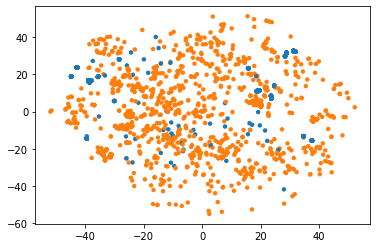

In [150]:
color_palette = sns.color_palette()
cluster_colors = [color_palette[x] if x >= 0
              else (0.5, 0.5, 0.5)
              for x in author_class]
plt.scatter(*proj[user_bool].T, s=20, linewidth=0, c=np.array(cluster_colors))

In [102]:
pd.DataFrame(output_dict).to_csv("bq_author_eval_metrics.csv", index=False)

In [57]:
user_freq_dist = user_counter.most_common(20)[:]
user_pair_set = set()
for user_x, _ in user_freq_dist:
    for user_y, _ in user_freq_dist:
        if user_x == user_y : continue
        if (user_x, user_y) in user_pair_set: continue
        if (user_y, user_x) in user_pair_set: continue
        user_pair_set.add((user_x, user_y))

In [58]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
db_index_baselines = []
db_indexes = []
user_1 = []
user_2 = []
user_1_count = []
user_2_count = []

with open("data/BigQuery/clusters/feature_set_2/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    X = bq_df[target_features].to_numpy()
    for user_x, user_y in tqdm(list(user_pair_set)):
        
        selected_users = [user_x, user_y]
        user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
        user_bool = bq_df['user_name'].apply(lambda user: user in selected_users)
        user_class = bq_df.loc[user_bool]["user_name"].apply(lambda user: user_to_idx[user]).to_numpy()  
        
        baseline_clusters = random_sample_clusters(bq_df.loc[user_bool], user_class)
        p_baseline = purity(baseline_clusters, user_class)
        db_index_baseline = davies_bouldin_score(X[user_bool], baseline_clusters)
        
        p = purity(labels[user_bool], user_class)
        db_index = davies_bouldin_score(X[user_bool], labels[user_bool])

        # color_palette = sns.color_palette('Set2', 110000)
        # cluster_colors = [color_palette[x] if x >= 0
        #               else (0.5, 0.5, 0.5)
        #               for x in cluster_pred.labels_]
        # cluster_member_colors = [sns.desaturate(x, p) for x, p in
        #                          zip(cluster_colors, cluster_pred.probabilities_)]
        # plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[repo_bool])
        
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        user_1 += [user_x]
        user_2 += [user_y]
        user_1_count += [user_counter[user_x]]
        user_2_count += [user_counter[user_y]]
        purity_baselines += [p_baseline]
        purities += [p]
        db_index_baselines += [db_index_baseline]
        db_indexes += [db_index]

output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "user_1" : user_1,
    "user_2" : user_2,
    "user_1_count" : user_1_count,
    "user_2_count" : user_2_count,
    "cluster_num" : cluster_nums,
    "purity_baseline" : purity_baselines,
    "purity" : purities,
    "db_index_baseline" : db_index_baselines,
    "db_index" : db_indexes,
}    

  0%|          | 0/190 [00:00<?, ?it/s]

In [59]:
pd.DataFrame(output_dict).to_csv("bq_user_pair_eval_metrics.csv", index=False)

# Repo Experiment

In [60]:
repo_counter = Counter(repos)
repo_freq_dist = repo_counter.most_common(5)[:]
selected_repos = get_high_freq_users(repo_freq_dist, 0)
repo_to_idx = {repo:idx for idx, repo in enumerate(selected_repos)}
repo_bool = bq_df['repo_name'].apply(lambda repo: repo in selected_repos)
repo_freq_dist

[('plotly.py', 1077),
 ('python-api', 927),
 ('azure-sdk-for-python', 844),
 ('google-research', 495),
 ('lambda-packs', 450)]

In [61]:
sample = bq_df[repo_bool].loc[:]
repo_class = sample["repo_name"].apply(lambda repo: repo_to_idx[repo]).to_numpy()

In [62]:
baseline_clusters = random_sample_clusters(sample, repo_class)
purity(baseline_clusters, repo_class)

0.28394410756657

In [63]:
purity(sample["cluster"].to_numpy(), repo_class)

0.3543369364619035

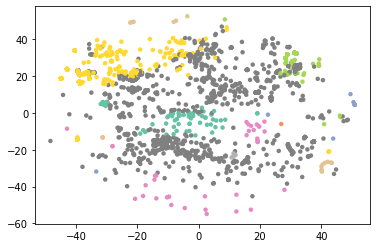

In [197]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
db_index_baselines = []
db_indexes = []
feat_1 = []
feat_2 = []

for pickle_file in pickle_files:
    with open(pickle_file["path"], "rb") as file:
        cluster_pred = pickle.load(file)
        labels = cluster_pred.labels_
        cluster_num = len(np.unique(labels))
        p = purity(labels[repo_bool], repo_class)
        X = bq_df[pickle_file["features"]].to_numpy()
        db_index = davies_bouldin_score(X[repo_bool], labels[repo_bool]) if len(np.unique(labels[repo_bool])) > 1 else 99999
        
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        feat_1 += [pickle_file["features"][0]]
        feat_2 += [pickle_file["features"][1]]
        purities += [p]
        db_indexes += [db_index]
        
with open("data/BigQuery/clusters/feature_set_2/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    p = purity(labels[repo_bool], repo_class)
    X = bq_df[target_features].to_numpy()
    db_index = davies_bouldin_score(X[repo_bool], labels[repo_bool])
    
    color_palette = sns.color_palette('Set2', 110000)
    cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in cluster_pred.labels_]
    cluster_member_colors = [sns.desaturate(x, p) for x, p in
                             zip(cluster_colors, cluster_pred.probabilities_)]
    plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[repo_bool])

    min_samples_params += [cluster_pred.min_samples]
    min_cluster_size_params += [cluster_pred.min_cluster_size]
    epsilon_params += [cluster_pred.cluster_selection_epsilon]
    cluster_nums += [cluster_num]
    feat_1 += ["full_feature"]
    feat_2 += ["full_feature"]
    purities += [p]
    db_indexes += [db_index]
    
output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "feat_1" : feat_1,
    "feat_2" : feat_2,
    "cluster_num" : cluster_nums,
    "purity" : purities,
    "db_index" : db_indexes
}

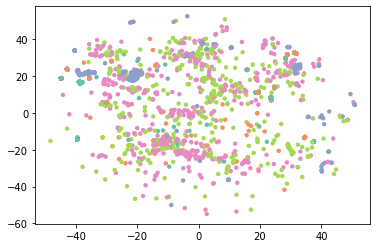

In [198]:
color_palette = sns.color_palette('Set2', 110000)
cluster_colors = [color_palette[x] if x >= 0
              else (0.5, 0.5, 0.5)
              for x in repo_class]
plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors))

In [199]:
pd.DataFrame(output_dict).to_csv("bq_repo_eval_metrics.csv", index=False)

In [64]:
repo_freq_dist = repo_counter.most_common(20)[:]
repo_pair_set = set()
for repo_x, _ in repo_freq_dist:
    for repo_y, _ in repo_freq_dist:
        if repo_x == repo_y : continue
        if (repo_x, repo_y) in repo_pair_set: continue
        if (repo_y, repo_x) in repo_pair_set: continue
        repo_pair_set.add((repo_x, repo_y))
        

In [65]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
db_index_baselines = []
db_indexes = []
repo_1 = []
repo_2 = []
repo_1_count = []
repo_2_count = []

with open("data/BigQuery/clusters/feature_set_2/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    X = bq_df[target_features].to_numpy()
    for repo_x, repo_y in tqdm(list(repo_pair_set)):
        
        selected_repos = [repo_x, repo_y]
        repo_to_idx = {repo:idx for idx, repo in enumerate(selected_repos)}
        repo_bool = bq_df['repo_name'].apply(lambda repo: repo in selected_repos)
        repo_class = bq_df.loc[repo_bool]["repo_name"].apply(lambda repo: repo_to_idx[repo]).to_numpy()   
        
        baseline_clusters = random_sample_clusters(bq_df.loc[repo_bool], repo_class)
        p_baseline = purity(baseline_clusters, repo_class)
        db_index_baseline = davies_bouldin_score(X[repo_bool], baseline_clusters)
        
        p = purity(labels[repo_bool], repo_class)
        db_index = davies_bouldin_score(X[repo_bool], labels[repo_bool])

        # color_palette = sns.color_palette('Set2', 110000)
        # cluster_colors = [color_palette[x] if x >= 0
        #               else (0.5, 0.5, 0.5)
        #               for x in cluster_pred.labels_]
        # cluster_member_colors = [sns.desaturate(x, p) for x, p in
        #                          zip(cluster_colors, cluster_pred.probabilities_)]
        # plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[repo_bool])
        
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        repo_1 += [repo_x]
        repo_2 += [repo_y]
        repo_1_count += [repo_counter[repo_x]]
        repo_2_count += [repo_counter[repo_y]]
        purity_baselines += [p_baseline]
        purities += [p]
        db_index_baselines += [db_index_baseline]
        db_indexes += [db_index]

output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "repo_1" : repo_1,
    "repo_2" : repo_2,
    "repo_1_count" : repo_1_count,
    "repo_2_count" : repo_2_count,
    "cluster_num" : cluster_nums,
    "purity_baseline" : purity_baselines,
    "purity" : purities,
    "db_index_baseline" : db_index_baselines,
    "db_index" : db_indexes,
}    

  0%|          | 0/190 [00:00<?, ?it/s]

In [66]:
pd.DataFrame(output_dict).to_csv("bq_repo_pair_eval_metrics.csv", index=False)

# Py150k

In [8]:
with open("data/py150/clusters/py150k_clusters.pickle", "rb") as file:
    py150k_cluster_pred = pickle.load(file)

In [9]:
len(py150k_cluster_pred.labels_)

100000

In [10]:
py150k_df = pd.read_csv("data/py150k_metric_20220527.csv")

In [11]:
py150k_df

,line_count,comment_count,comment_total_len,comment_avg_len,comment_density,id_total,lower_case,id_total_var,lower_case_var,snake_case_ratio,...,comprehensions,lower_camel_case_method,lower_case_class,snake_case_class,upper_camel_case_method,other_case_method,upper_case_method,lower_camel_case_class,upper_case_class,path
0,116,2,44.0,22.000000,0.017241,1.0,1.0,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/00/wikihouse/urls.py
1,363,24,1244.0,51.833333,0.066116,381.0,214.0,333.0,195.0,0.341207,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/0rpc/zerorpc-pytho...
2,13,1,21.0,21.000000,0.076923,3.0,3.0,3.0,3.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/0xadada/dockdj/app...
3,34,0,0.0,0.000000,0.000000,26.0,18.0,26.0,18.0,0.307692,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/1stvamp/hippybot/s...
4,11,1,21.0,21.000000,0.090909,3.0,3.0,3.0,3.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/2buntu/2buntu-blog...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,31,15,645.0,43.000000,0.483871,8.0,4.0,7.0,4.0,0.125000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/Havate/havate-open...
99996,61,21,807.0,38.428571,0.344262,29.0,13.0,25.0,13.0,0.448276,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/Havate/havate-open...
99997,642,18,771.0,42.833333,0.028037,606.0,359.0,558.0,345.0,0.270627,...,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/Havate/havate-open...
99998,400,20,846.0,42.300000,0.050000,380.0,224.0,351.0,221.0,0.263158,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,data/py150/py150_files/data/Havate/havate-open...


In [12]:
users = []
repos = []
for path in py150k_df["path"]:
    temp = path.split("/")
    users += [temp[4]]
    repos += [temp[5]]

py150k_df["user_name"] = users
py150k_df["repo_name"] = repos 

In [15]:
#internal metrics are generated now and everything is stored in dataframe should be ready for clustering
target_features = [
     'snake_case_var_ratio',
     'snake_case_class_ratio',
     'snake_case_method_ratio',
     'upper_camel_case_var_ratio',
     'upper_camel_case_class_ratio',
     'upper_camel_case_method_ratio',
     'lower_camel_case_var_ratio',
     'lower_camel_case_class_ratio',
     'lower_camel_case_method_ratio',
     'func_decorators_avg',
     'class_decorators_avg',
     'class_parents_avg',
     'comprehensions_avg',
     'generators_avg',
     'lambda_avg',
     'comment_density',
     'ds_density',
]
X = py150k_df[target_features].to_numpy()
X.shape

NameError: name 'py150k_df' is not defined

In [18]:
user_counter = Counter(users)
user_freq_dist = user_counter.most_common(2)[:]
selected_users = get_high_freq_users(user_freq_dist, 0)
user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
user_bool = py150k_df['user_name'].apply(lambda user: user in selected_users)
user_freq_dist

[('anhstudios', 5069), ('openstack', 3111)]

In [36]:
user_freq_dist = user_counter.most_common(20)[:]
user_pair_set = set()
for user_x, _ in user_freq_dist:
    for user_y, _ in user_freq_dist:
        if user_x == user_y : continue
        if (user_x, user_y) in user_pair_set: continue
        if (user_y, user_x) in user_pair_set: continue
        user_pair_set.add((user_x, user_y))

In [37]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
db_index_baselines = []
db_indexes = []
user_1 = []
user_2 = []
user_1_count = []
user_2_count = []

with open("data/py150/clusters/py150k_clusters.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    X = py150k_df[target_features].to_numpy()
    for user_x, user_y in tqdm(list(user_pair_set)):
        
        selected_users = [user_x, user_y]
        user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
        user_bool = py150k_df['user_name'].apply(lambda user: user in selected_users)
        user_class = py150k_df.loc[user_bool]["user_name"].apply(lambda user: user_to_idx[user]).to_numpy()   
        
        baseline_clusters = random_sample_clusters(py150k_df.loc[user_bool], user_class)
        p_baseline = purity(baseline_clusters, user_class)
        db_index_baseline = davies_bouldin_score(X[user_bool], baseline_clusters)
        
        p = purity(labels[user_bool], user_class)
        db_index = davies_bouldin_score(X[user_bool], labels[user_bool])

        # color_palette = sns.color_palette('Set2', 110000)
        # cluster_colors = [color_palette[x] if x >= 0
        #               else (0.5, 0.5, 0.5)
        #               for x in cluster_pred.labels_]
        # cluster_member_colors = [sns.desaturate(x, p) for x, p in
        #                          zip(cluster_colors, cluster_pred.probabilities_)]
        # plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[repo_bool])
        
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        user_1 += [user_x]
        user_2 += [user_y]
        user_1_count += [user_counter[user_x]]
        user_2_count += [user_counter[user_y]]
        purity_baselines += [p_baseline]
        purities += [p]
        db_index_baselines += [db_index_baseline]
        db_indexes += [db_index]
output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "user_1" : user_1,
    "user_2" : user_2,
    "user_1_count" : user_1_count,
    "user_2_count" : user_2_count,
    "cluster_num" : cluster_nums,
    "purity_baseline" : purity_baselines,
    "purity" : purities,
    "db_index_baseline" : db_index_baselines,
    "db_index" : db_indexes,
}    

  0%|          | 0/190 [00:00<?, ?it/s]

In [38]:
pd.DataFrame(output_dict).to_csv("py150k_user_pair_eval_metrics.csv", index=False)

In [31]:
repo_counter = Counter(repos)
repo_freq_dist = repo_counter.most_common(5)[:]
selected_repos = get_high_freq_users(repo_freq_dist, 0)
repo_to_idx = {repo:idx for idx, repo in enumerate(selected_repos)}
repo_bool = py150k_df['repo_name'].apply(lambda repo: repo in selected_repos)
repo_freq_dist

[('swganh', 5069),
 ('appscale', 1882),
 ('hue', 989),
 ('plexnet', 852),
 ('commcare-hq', 780)]

In [32]:
repo_freq_dist = repo_counter.most_common(20)[:]
repo_pair_set = set()
for repo_x, _ in repo_freq_dist:
    for repo_y, _ in repo_freq_dist:
        if repo_x == repo_y : continue
        if (repo_x, repo_y) in repo_pair_set: continue
        if (repo_y, repo_x) in repo_pair_set: continue
        repo_pair_set.add((repo_x, repo_y))
    

In [34]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
db_index_baselines = []
db_indexes = []
repo_1 = []
repo_2 = []
repo_1_count = []
repo_2_count = []

with open("data/py150/clusters/py150k_clusters.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    X = py150k_df[target_features].to_numpy()
    for repo_x, repo_y in tqdm(list(repo_pair_set)):
        
        selected_repos = [repo_x, repo_y]
        repo_to_idx = {repo:idx for idx, repo in enumerate(selected_repos)}
        repo_bool = py150k_df['repo_name'].apply(lambda repo: repo in selected_repos)
        repo_class = py150k_df.loc[repo_bool]["repo_name"].apply(lambda repo: repo_to_idx[repo]).to_numpy()     
        
        baseline_clusters = random_sample_clusters(py150k_df.loc[repo_bool], repo_class)
        p_baseline = purity(baseline_clusters, repo_class)
        db_index_baseline = davies_bouldin_score(X[repo_bool], baseline_clusters)
        
        p = purity(labels[repo_bool], repo_class)
        db_index = davies_bouldin_score(X[repo_bool], labels[repo_bool])

        # color_palette = sns.color_palette('Set2', 110000)
        # cluster_colors = [color_palette[x] if x >= 0
        #               else (0.5, 0.5, 0.5)
        #               for x in cluster_pred.labels_]
        # cluster_member_colors = [sns.desaturate(x, p) for x, p in
        #                          zip(cluster_colors, cluster_pred.probabilities_)]
        # plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[repo_bool])
        
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        repo_1 += [repo_x]
        repo_2 += [repo_y]
        repo_1_count += [repo_counter[repo_x]]
        repo_2_count += [repo_counter[repo_y]]
        purity_baselines += [p_baseline]
        purities += [p]
        db_index_baselines += [db_index_baseline]
        db_indexes += [db_index]

output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "repo_1" : repo_1,
    "repo_2" : repo_2,
    "repo_1_count" : repo_1_count,
    "repo_2_count" : repo_2_count,
    "cluster_num" : cluster_nums,
    "purity_baseline" : purity_baselines,
    "purity" : purities,
    "db_index_baseline" : db_index_baselines,
    "db_index" : db_indexes,
}    

  0%|          | 0/190 [00:00<?, ?it/s]

In [35]:
pd.DataFrame(output_dict).to_csv("py150k_repo_pair_eval_metrics.csv", index=False)

# Combined Dataset

In [26]:
from tqdm.auto import tqdm
#internal metrics are generated now and everything is stored in dataframe should be ready for clustering
target_features = [
     'snake_case_var_ratio',
     'snake_case_class_ratio',
     'snake_case_method_ratio',
     'upper_camel_case_var_ratio',
     'upper_camel_case_class_ratio',
     'upper_camel_case_method_ratio',
     'lower_camel_case_var_ratio',
     'lower_camel_case_class_ratio',
     'lower_camel_case_method_ratio',
     'func_decorators_avg',
     'class_decorators_avg',
     'class_parents_avg',
     'comprehensions_avg',
     'generators_avg',
     'lambda_avg',
     'comment_density',
     'ds_density',
]

In [15]:
combined_df = pd.concat([py150k_df[target_features], bq_df[target_features]])

In [16]:
with open("data/combined_dataset/clusters/feature_set_1/full_feature_clusterer.pickle", "rb") as file:
    combined_cluster_pred = pickle.load(file)

In [17]:
users = []
repos = []
for path in py150k_df["path"]:
    temp = path.split("/")
    users += [temp[4]]
    repos += [temp[5]]

for user_repo in bq_df["repository"]:
    temp = user_repo.split("/")
    users += [temp[0]]
    repos += [temp[1]]

combined_df["user_name"] = users
combined_df["repo_name"] = repos 

In [18]:
c = Counter(combined_df[["user_name", "repo_name"]][combined_df["user_name"] == "anhstudios"]["repo_name"].to_numpy())

In [19]:
c.most_common(1)

[('swganh', 5069)]

In [20]:
len(combined_cluster_pred.labels_)

215050

In [21]:
user_counter = Counter(users)
user_freq_dist = user_counter.most_common(2)[:]
selected_users = get_high_freq_users(user_freq_dist, 0)
user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
user_bool = combined_df['user_name'].apply(lambda user: user in selected_users)
user_freq_dist

[('anhstudios', 5069), ('openstack', 3111)]

In [52]:
combined_df[combined_df['user_name']=="anhstudios"].mean()

<ipython-input-52-ed024c897ef0>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined_df[combined_df['user_name']=="anhstudios"].mean()


snake_case_var_ratio             0.200791
snake_case_class_ratio           0.000000
snake_case_method_ratio          0.000395
upper_camel_case_var_ratio       0.000293
upper_camel_case_class_ratio     0.003354
upper_camel_case_method_ratio    0.000197
lower_camel_case_var_ratio       0.202278
lower_camel_case_class_ratio     0.000000
lower_camel_case_method_ratio    0.002565
func_decorators_avg              0.000000
class_decorators_avg             0.000000
class_parents_avg                0.003156
comprehensions_avg               0.000000
generators_avg                   0.000000
lambda_avg                       0.000000
comment_density                  0.292438
ds_density                       0.000037
dtype: float64

In [53]:
combined_df[combined_df['user_name']=="plotly"].mean()

<ipython-input-53-e8376316967e>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  combined_df[combined_df['user_name']=="plotly"].mean()


snake_case_var_ratio             0.334153
snake_case_class_ratio           0.001968
snake_case_method_ratio          0.890934
upper_camel_case_var_ratio       0.092542
upper_camel_case_class_ratio     0.897688
upper_camel_case_method_ratio    0.000000
lower_camel_case_var_ratio       0.000317
lower_camel_case_class_ratio     0.000000
lower_camel_case_method_ratio    0.001140
func_decorators_avg              0.086536
class_decorators_avg             0.001968
class_parents_avg                0.945811
comprehensions_avg               0.000126
generators_avg                   0.000051
lambda_avg                       0.000013
comment_density                  0.009980
ds_density                       0.040434
dtype: float64

In [24]:
user_freq_dist = user_counter.most_common(20)[:]
user_pair_set = set()
for user_x, _ in user_freq_dist:
    for user_y, _ in user_freq_dist:
        if user_x == user_y : continue
        if (user_x, user_y) in user_pair_set: continue
        if (user_y, user_x) in user_pair_set: continue
        user_pair_set.add((user_x, user_y))

In [49]:
def purity(cluster_labels, gold_labels, outlier_disable=False):
    cluster_num = np.unique(cluster_labels).shape[0]
    cluster_sets = {}
    for cluster_label in np.unique(cluster_labels):
        cluster_sets[cluster_label] = []
    
    for idx, cluster_label in enumerate(cluster_labels):
        cluster_sets[cluster_label].append(gold_labels[idx])
    
    total_correct_pred = 0
    for c in np.unique(cluster_labels):
        if c == -1 and outlier_disable:
            continue
        label_counter = Counter(cluster_sets[c])
        pred_label, _ = label_counter.most_common(1)[0]
        total_correct_pred += label_counter[pred_label]
    
    purity = total_correct_pred / len(cluster_labels)
    
    return purity


In [50]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
purities_non_outlier = []
db_index_baselines = []
db_indexes = []
user_1 = []
user_2 = []
user_1_count = []
user_2_count = []
user_1_outlier_count = []
user_2_outlier_count = []

with open("data/combined_dataset/clusters/feature_set_1/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    X = combined_df[target_features].to_numpy()
    
    for user_x, user_y in tqdm(list(user_pair_set)):
        
        selected_users = [user_x, user_y]
        user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
        user_bool = combined_df['user_name'].apply(lambda user: user in selected_users)
        user_class = combined_df.loc[user_bool]["user_name"].apply(lambda user: user_to_idx[user]).to_numpy()
        
        non_outlier_bool = labels[user_bool] != -1
        non_outlier_users = combined_df['user_name'][user_bool].to_numpy()[non_outlier_bool]
        non_outlier_users_counter = Counter(non_outlier_users)
        
        baseline_clusters = random_sample_clusters(combined_df.loc[user_bool], user_class)
        p_baseline = purity(baseline_clusters, user_class)
        
        db_index_baseline = davies_bouldin_score(X[user_bool], baseline_clusters)
        
        p = purity(labels[user_bool], user_class)
        p_non_outlier = purity(labels[user_bool], user_class, outlier_disable=True)
        
        db_index = davies_bouldin_score(X[user_bool], labels[user_bool])

        # color_palette = sns.color_palette('Set2', 110000)
        # cluster_colors = [color_palette[x] if x >= 0
        #               else (0.5, 0.5, 0.5)
        #               for x in cluster_pred.labels_]
        # cluster_member_colors = [sns.desaturate(x, p) for x, p in
        #                          zip(cluster_colors, cluster_pred.probabilities_)]
        # plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[repo_bool])
    
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        user_1 += [user_x]
        user_2 += [user_y]
        user_1_count += [user_counter[user_x]]
        user_2_count += [user_counter[user_y]]
        user_1_outlier_count += [non_outlier_users_counter[user_x]]
        user_2_outlier_count += [non_outlier_users_counter[user_y]]
        purity_baselines += [p_baseline]
        purities += [p]
        purities_non_outlier += [p_non_outlier]
        db_index_baselines += [db_index_baseline]
        db_indexes += [db_index]
output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "user_1" : user_1,
    "user_2" : user_2,
    "user_1_count" : user_1_count,
    "user_2_count" : user_2_count,
    "user_1_non_outlier_count" : user_1_outlier_count,
    "user_2_non_outlier_count" : user_2_outlier_count,
    "cluster_num" : cluster_nums,
    "purity_baseline" : purity_baselines,
    "purity" : purities,
    "purity_non_outlier" : purities_non_outlier,
    "db_index_baseline" : db_index_baselines,
    "db_index" : db_indexes,
}

  0%|          | 0/190 [00:00<?, ?it/s]

In [51]:
pd.DataFrame(output_dict).to_csv("combined_user_pair_eval_metrics_no_outliers.csv", index=False)
# pd.DataFrame(output_dict).to_csv("combined_user_pair_eval_metrics.csv", index=False)

In [87]:
repo_counter = Counter(repos)
repo_freq_dist = repo_counter.most_common(5)[:]
selected_repos = get_high_freq_users(repo_freq_dist, 0)
repo_to_idx = {repo:idx for idx, repo in enumerate(selected_repos)}
repo_bool = combined_df['repo_name'].apply(lambda repo: repo in selected_repos)
repo_freq_dist

[('swganh', 5069),
 ('appscale', 1882),
 ('azure-sdk-for-python', 1255),
 ('plotly.py', 1106),
 ('hue', 1013)]

In [88]:
repo_freq_dist = repo_counter.most_common(20)[:]
repo_pair_set = set()
for repo_x, _ in repo_freq_dist:
    for repo_y, _ in repo_freq_dist:
        if repo_x == repo_y : continue
        if (repo_x, repo_y) in repo_pair_set: continue
        if (repo_y, repo_x) in repo_pair_set: continue
        repo_pair_set.add((repo_x, repo_y))
    

In [89]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
db_index_baselines = []
db_indexes = []
repo_1 = []
repo_2 = []
repo_1_count = []
repo_2_count = []

with open("data/combined_dataset/clusters/feature_set_1/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    X = combined_df[target_features].to_numpy()
    for repo_x, repo_y in tqdm(list(repo_pair_set)):
        
        selected_repos = [repo_x, repo_y]
        repo_to_idx = {repo:idx for idx, repo in enumerate(selected_repos)}
        repo_bool = combined_df['repo_name'].apply(lambda repo: repo in selected_repos)
        repo_class = combined_df.loc[repo_bool]["repo_name"].apply(lambda repo: repo_to_idx[repo]).to_numpy()     
        
        baseline_clusters = random_sample_clusters(combined_df.loc[repo_bool], repo_class)
        p_baseline = purity(baseline_clusters, repo_class)
        db_index_baseline = davies_bouldin_score(X[repo_bool], baseline_clusters)
        
        p = purity(labels[repo_bool], repo_class)
        db_index = davies_bouldin_score(X[repo_bool], labels[repo_bool])

        # color_palette = sns.color_palette('Set2', 110000)
        # cluster_colors = [color_palette[x] if x >= 0
        #               else (0.5, 0.5, 0.5)
        #               for x in cluster_pred.labels_]
        # cluster_member_colors = [sns.desaturate(x, p) for x, p in
        #                          zip(cluster_colors, cluster_pred.probabilities_)]
        # plt.scatter(*proj[repo_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[repo_bool])
        
        min_samples_params += [cluster_pred.min_samples]
        min_cluster_size_params += [cluster_pred.min_cluster_size]
        epsilon_params += [cluster_pred.cluster_selection_epsilon]
        cluster_nums += [cluster_num]
        repo_1 += [repo_x]
        repo_2 += [repo_y]
        repo_1_count += [repo_counter[repo_x]]
        repo_2_count += [repo_counter[repo_y]]
        purity_baselines += [p_baseline]
        purities += [p]
        db_index_baselines += [db_index_baseline]
        db_indexes += [db_index]

output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "repo_1" : repo_1,
    "repo_2" : repo_2,
    "repo_1_count" : repo_1_count,
    "repo_2_count" : repo_2_count,
    "cluster_num" : cluster_nums,
    "purity_baseline" : purity_baselines,
    "purity" : purities,
    "db_index_baseline" : db_index_baselines,
    "db_index" : db_indexes,
}    

  0%|          | 0/190 [00:00<?, ?it/s]

In [90]:
pd.DataFrame(output_dict).to_csv("combined_repo_pair_eval_metrics.csv", index=False)

In [8]:
popular_metrics = [
    "forks",
    "issue_events",
    "stars",
]

In [9]:
pop_feat_x = bq_df[popular_metrics].to_numpy()

In [13]:
with open("popular_cluster.pickle", "rb") as file:
    cluster_pred = pickle.load(file)


In [17]:
pop_class = cluster_pred.labels_

In [18]:
target_features = [
     'snake_case_var_ratio',
     'snake_case_class_ratio',
     'snake_case_method_ratio',
     'upper_camel_case_var_ratio',
     'upper_camel_case_class_ratio',
     'upper_camel_case_method_ratio',
     'lower_camel_case_var_ratio',
     'lower_camel_case_class_ratio',
     'lower_camel_case_method_ratio',
     'func_decorators_avg',
     'class_decorators_avg',
     'class_parents_avg',
     'comprehensions_avg',
     'generators_avg',
     'lambda_avg',
     'comment_density',
     'ds_density',
]

In [24]:

min_samples_params = []
min_cluster_size_params = []
epsilon_params = []
cluster_nums = []
purity_baselines = []
purities = []
db_index_baselines = []
db_indexes = []

with open("data/BigQuery/clusters/feature_set_2/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)
    labels = cluster_pred.labels_
    cluster_num = len(np.unique(labels))
    X = bq_df[target_features].to_numpy()
    
    baseline_clusters = random_sample_clusters(bq_df.loc[:], pop_class)
    p_baseline = purity(baseline_clusters, pop_class)
    db_index_baseline = davies_bouldin_score(X[:], baseline_clusters)

    p = purity(labels[:], pop_class)
    db_index = davies_bouldin_score(X[:], labels[:])
        
    min_samples_params += [cluster_pred.min_samples]
    min_cluster_size_params += [cluster_pred.min_cluster_size]
    epsilon_params += [cluster_pred.cluster_selection_epsilon]
    cluster_nums += [cluster_num]
    purity_baselines += [p_baseline]
    purities += [p]
    db_index_baselines += [db_index_baseline]
    db_indexes += [db_index]

output_dict = {
    "min_samples_param" : min_samples_params,
    "min_cluster_size_param" : min_cluster_size_params,
    "epsilon_param" : epsilon_params,
    "cluster_num" : cluster_nums,
    "purity_baseline" : purity_baselines,
    "purity" : purities,
    "db_index_baseline" : db_index_baselines,
    "db_index" : db_indexes,
}    

In [25]:
output_dict

{'min_samples_param': [100],
 'min_cluster_size_param': [500],
 'epsilon_param': [0.01],
 'cluster_num': [15],
 'purity_baseline': [0.6994697957409822],
 'purity': [0.6994697957409822],
 'db_index_baseline': [252.74251382262602],
 'db_index': [1.2495997642694248]}

In [26]:
combined_df

NameError: name 'combined_df' is not defined

In [32]:
from tqdm.auto import tqdm
projections = []
with open("data/combined_dataset/clusters/feature_set_1/projection.txt") as f:
    for line in tqdm(f.readlines()):
        val_str_list = line.split()
        projections += [[float(val_str_list[0]), float(val_str_list[1])]]
proj = np.array(projections)

  0%|          | 0/215050 [00:00<?, ?it/s]

In [34]:
import pickle
with open("data/combined_dataset/clusters/feature_set_1/full_feature_clusterer.pickle", "rb") as file:
    cluster_pred = pickle.load(file)


In [44]:

selected_users = ['anhstudios', 'openstack']
user_to_idx = {user:idx for idx, user in enumerate(selected_users)}
user_bool = combined_df['user_name'].apply(lambda user: user in selected_users)
user_class = combined_df.loc[user_bool]["user_name"].apply(lambda user: user_to_idx[user]).to_numpy()   

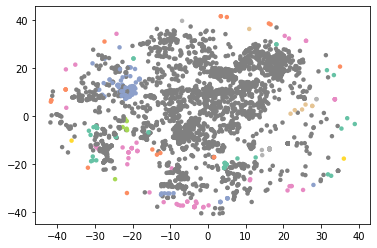

In [52]:
import seaborn as sns
color_palette = sns.color_palette('Set2', 110000)
cluster_colors = [color_palette[x] if x >= 0
              else (0.5, 0.5, 0.5)
              for x in cluster_pred.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, cluster_pred.probabilities_)]
plt.scatter(*proj[user_bool].T, s=20, linewidth=0, c=np.array(cluster_colors)[user_bool])

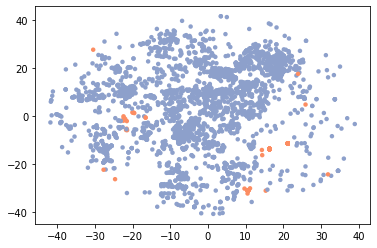

In [63]:
color_palette = sns.color_palette('Set2', 100)
cluster_colors = [color_palette[x+1] if x >= 0
              else (0.5, 0.5, 0.5)
              for x in user_class]
plt.scatter(*proj[user_bool].T, s=20, linewidth=0, c=np.array(cluster_colors))

In [55]:
Counter(user_class)

Counter({0: 5069, 1: 3111})

In [64]:
user_1_bool = combined_df['user_name'].apply(lambda user: user == 'anhstudios')
user_2_bool = combined_df['user_name'].apply(lambda user: user == 'openstack')

In [76]:
proj[user_1_bool].shape

(5069, 2)

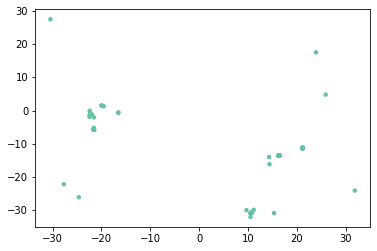

In [66]:
color_palette = sns.color_palette('Set2', 100)
cluster_colors = [color_palette[0]] * np.sum(user_1_bool)
plt.scatter(*proj[user_1_bool].T, s=20, linewidth=0, c=np.array(cluster_colors))

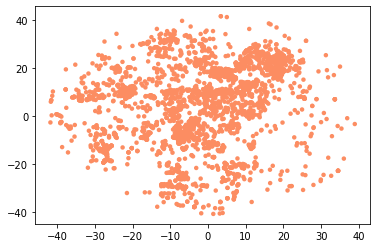

In [70]:
color_palette = sns.color_palette('Set2', 100)
cluster_colors = [color_palette[1]] * np.sum(user_2_bool)
plt.scatter(*proj[user_2_bool].T, s=20, linewidth=0, c=np.array(cluster_colors))

In [75]:
def purity(cluster_labels, gold_labels):
    cluster_num = np.unique(cluster_labels).shape[0]
    cluster_sets = {}
    for cluster_label in np.unique(cluster_labels):
        cluster_sets[cluster_label] = []
    
    for idx, cluster_label in enumerate(cluster_labels):
        cluster_sets[cluster_label].append(gold_labels[idx])
    
    total_correct_pred = 0
    for c in np.unique(cluster_labels):
        label_counter = Counter(cluster_sets[c])
        print(label_counter)
        pred_label, _ = label_counter.most_common(1)[0]
        total_correct_pred += label_counter[pred_label]
    print(total_correct_pred)
    print(len(cluster_labels))
    purity = total_correct_pred / len(cluster_labels)
    
    return purity
purity(cluster_pred.labels_[user_bool], user_class)

Counter({1: 2867, 0: 116})
Counter({1: 1, 0: 1})
Counter({1: 3})
Counter({1: 1})
Counter({1: 4})
Counter({0: 1})
Counter({1: 1})
Counter({1: 5, 0: 1})
Counter({0: 4946})
Counter({1: 37})
Counter({1: 3})
Counter({1: 80})
Counter({1: 8})
Counter({1: 1})
Counter({1: 1})
Counter({1: 1})
Counter({1: 7})
Counter({1: 15})
Counter({1: 18})
Counter({1: 49})
Counter({0: 4, 1: 3})
Counter({1: 2})
Counter({1: 4})
8059
8180


0.9852078239608802